# **Exploratory Data Analysis**



## **1. Project Setup**

#### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from lcz_classification.config import *
from lcz_classification.util import read_lcz_legend, normalize_arr, jeffries_matuista_distance, band_stats, kml_to_gdf
from lcz_classification.plots import plot_spectral_signature, pairwise_plot, plot_pixel_counts
from lcz_classification.dataset import fetch_metadata

from shapely.geometry import box
import geopandas as gpd
from rasterstats import zonal_stats
import rioxarray as rio
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

- Parent directory for Toronto already exists, retrievine folder paths...
- Folder paths for Toronto retrieved.


#### 1.2. Setup Paths

In [11]:
study_area = fetch_metadata('STUDY_AREA')
UTM_CRS=study_area.estimate_utm_crs()

lcz_legend, color_dict=read_lcz_legend(LCZ_LEGEND_FP)
label_dict=lcz_legend.set_index('class')['name'].to_dict()
lcz_gdf=kml_to_gdf(LCZ_FP).to_crs(UTM_CRS)

s2_metadata=fetch_metadata('S2_METADATA')

Non-valid Layer: Greater Toronto_5/8/2018_JL
Non-valid Layer: 7
Non-valid Layer: 8
Non-valid Layer: 9
Non-valid Layer: 10
Non-valid Layer: C
Non-valid Layer: F


#### 1.3. Load Data

In [3]:
s2=rio.open_rasterio(S2_FP)
s2_bands=eval(s2.attrs['bands'])
s2['band'] = s2_bands
s2 = s2 / 10000
## URBAN CANOPY PARAMETERS ##

bh=rio.open_rasterio(BH_FP) # Building Height
ch=rio.open_rasterio(CH_FP) # Tree Canopy Height
isf=rio.open_rasterio(IS_FP) # Impervious Surface Fraction
bsf=rio.open_rasterio(BS_FP) # Building Surface Fraction
# svf=rio.open_rasterio(SF_FP) # Sky View Factor
train=rio.open_rasterio(TRAIN_FP) # Training Areas of Local Climate Zones  (Class Layer)
test=rio.open_rasterio(TEST_FP) # Testing Areas of Local Climate Zones Rasterized (Class Layer)

features=s2_bands.copy()
features.extend(['Building Height', 'Canopy Height', 'Impervious Surface Fraction', 'Building Surface Fraction'])


## 2. Compare Pixel Counts Between Train / Test

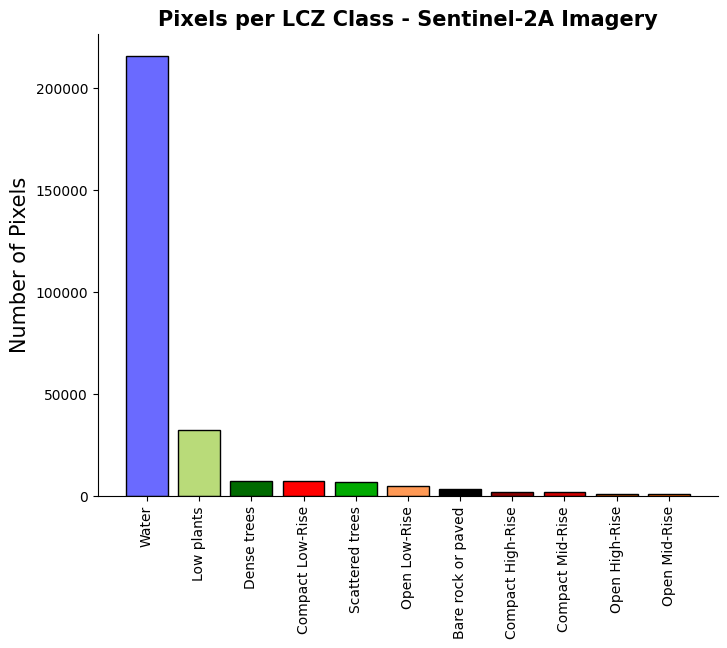

In [4]:
lcz_values=train.values.reshape(-1)
lcz_values=lcz_values[lcz_values > 0]
lcz_values_df=pd.DataFrame(lcz_values, columns = ["class"])
lcz_px_counts=lcz_values_df.value_counts().reset_index().sort_values("count")
lcz_px_counts["class"] = [label_dict[x] for x in np.int16(lcz_px_counts['class'])]
lcz_px_counts['color']=[lcz_legend.set_index('name').loc[x].hex for x in lcz_px_counts['class']]


plot_pixel_counts(
    pixel_count_df=lcz_px_counts,
    count_col='count',
    class_col='class',
    color_col='color',
    title='Pixels per LCZ Class - Sentinel-2A Imagery',
    out_file=f"{FIGURES_DIR}/s2_pixel_counts.png",
    as_percent=False
)

## **2. Spectral Signatures of LCZs Sentinel-2**

#### 2.1 Calculate Band Statistics of LCZ Training Samples from Sentinel-2 Imagery

In [ ]:
lcz_gdf.geometry=lcz_gdf.buffer(-0.0001).buffer(0.0001)
# Retrieve MultiPolygons of each LCZ Class
zones=lcz_gdf.dissolve(by="Name")

# Use LCZ MultiPolygons to Computer Sentinel-2 band statistics for each LCZ 
band_stats_df=band_stats(zones,s2)

# Map S2A wavelengths in nanometers (nm) to band names for plotting
s2a_wl_dict=s2_metadata.set_index('band').wavelength_nm.to_dict()
band_stats_df['wavelength_nm'] = band_stats_df.band.apply(lambda x: s2a_wl_dict[x])
band_stats_df=band_stats_df.sort_values('wavelength_nm')
band_stats_df=band_stats_df.set_index('Name').join(lcz_legend.set_index('class_id')).reset_index()

#### 2.1 Plot LCZ Spectral Signatures

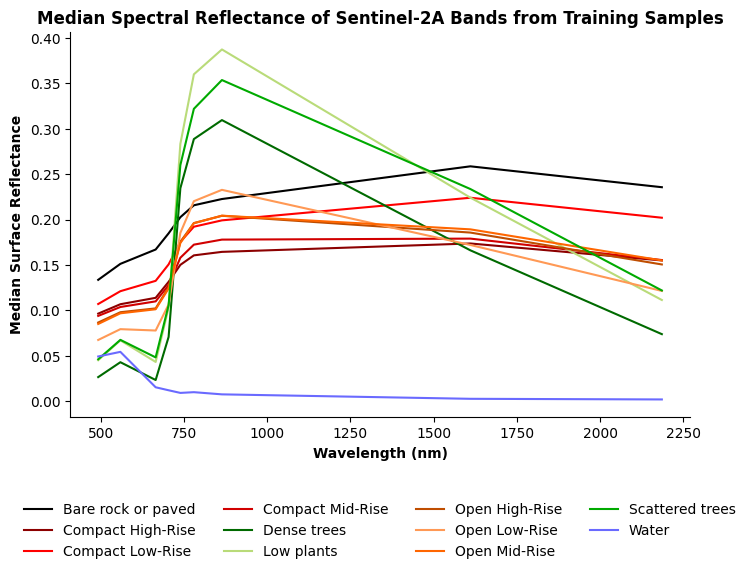

In [18]:

plot_spectral_signature(
    band_stats=band_stats_df,
    x_col='wavelength_nm',
    class_col='name',
    color_dict=color_dict,
    title = "Median Spectral Reflectance of Sentinel-2A Bands from Training Samples",
    xlabel= "Wavelength (nm)",
    stat='median',
    out_file=f"{FIGURES_DIR}/s2_spectral_signature.png"
)

## **3. Jeffries-Matuista Distance of LCZ Training Areas**

#### 3.1. Compute Jeffries-Matuista Distance Sentinel-2 Imagery

In [19]:
classes=band_stats_df.reset_index().Name.unique()

X_clipped=[s2.rio.clip([zones.loc[class_name].geometry], crs=zones.crs,drop=True).values for class_name in classes]

X_clipped=[X.reshape(-1, X.shape[0]) for X in X_clipped]
X_clipped=[X[~np.isnan(X).any(axis=1)] for X in X_clipped] 
X_dict=dict(zip(classes,X_clipped))

class_pairs=[[cl1,cl2] for cl2 in classes for cl1 in classes]

jm_list=list()

for pair in class_pairs:
    f1, f2 = pair
    x = X_dict[f1]
    y = X_dict[f2]
    jm_list.append(jeffries_matuista_distance(x,y))



class1 = [p[0] for p in class_pairs]
class2 = [p[1] for p in class_pairs]

df=pd.DataFrame(dict(
    class1=class1,
    class2=class2,
    jm=jm_list
))




#### 3.1. Plot Jeffries-Matuista Distance Matrix from Sentinel-2 Imagery

<Figure size 640x480 with 0 Axes>

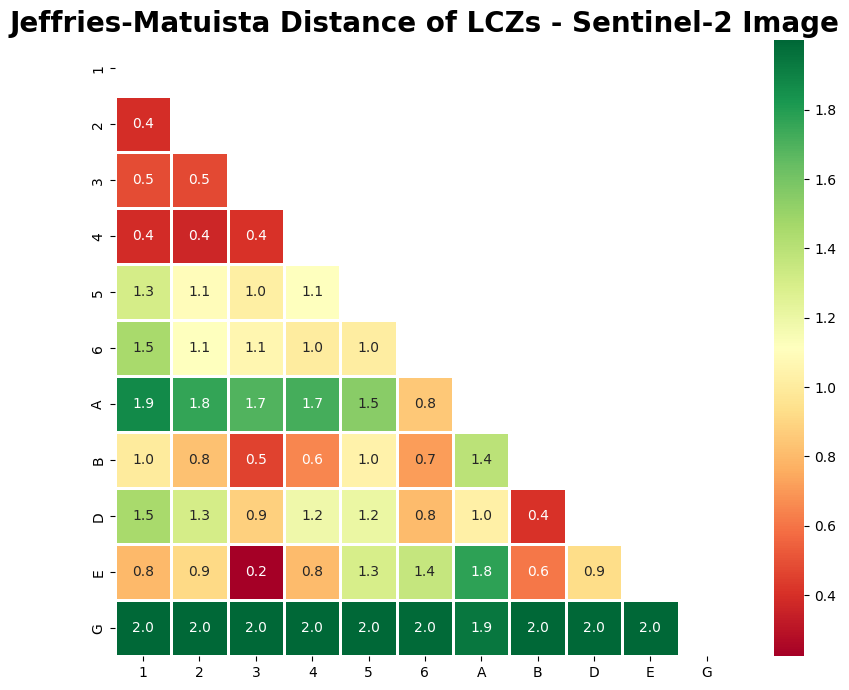

In [20]:

pairwise_plot(df=df,
              class1='class1',
              class2='class2',
              dist_col='jm',
              title='Jeffries-Matuista Distance of LCZs - Sentinel-2 Image',
              out_file=f'{FIGURES_DIR}/s2_jm.png'
              )